# Quick word on Python notebook files.
### Make sure you run ALL the prior code cells
### Running a cell only runs the code INSIDE the cell
#### Variables, functions, etc from cells previously ran can be accessed.
#### Try running the 3 cells below and get `print(hi)` to work without adding any code

In [93]:
# Example
print(hi)

hello


In [90]:
hi = 5

In [92]:
hi = "hello"

### Import Statements

In [1]:
import torch
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression as skLinearRegression

## Linear Regression Model Class

In [18]:
class LinearRegression:
    def __init__(self, num_inputs, lr, sigma=0.01):
        self.num_inputs = num_inputs
        self.lr = lr
        self.sigma = sigma
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)
        
        self.train_epoch = []
        self.train_loss = []
        self.val_epoch = []
        self.val_loss = []
        
    def forward(self, X):
        return torch.matmul(X, self.w) + self.b
    
    def loss(self, y_hat, y):
        l = (y_hat - y.reshape(y_hat.shape)) ** 2 / 2
        return l.mean()
    
    def configure_optimizers(self):
        return SGD([self.w, self.b], self.lr)
    
    def training_step(self, batch, idx):
        l = self.loss(self.forward(batch[:, :-1]), batch[:, -1])
        self.train_epoch.append(idx)
        self.train_loss.append(l.detach().numpy())
        return l
    
    def validation_step(self, val, idx):
        l = self.loss(self.forward(val[:, :-1]), val[:, -1])
        self.val_epoch.append(idx)
        self.val_loss.append(l.detach().numpy())
        
    def plot(self):
        plt.plot(self.train_epoch, self.train_loss, label = "train")
        plt.plot(self.val_epoch, self.val_loss, label = "validation")
        plt.legend()
        plt.show()

## Stochastic Gradient Decent Class

In [9]:
class SGD:
    def __init__(self, params, lr):
        self.params = params
        self.lr = lr
    
    def step(self):
        for param in self.params:
            param -= self.lr * param.grad
    
    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

## Trainer Class

In [7]:
class Trainer:
    def __init__(self, max_epochs):
        self.max_epochs = max_epochs
    
    def prepare_data(self, data, batch_size):
        self.train_dataloader = data.train_dataloader(batch_size)
        self.val_data = data.val_data()
        self.batch_train = batch_size / data.train_len()
    
    def prepare_model(self, model):
        self.model = model
    
    def fit(self, model, data, batch_size):
        self.prepare_data(data, batch_size)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()
            with torch.no_grad():
                self.model.validation_step(self.val_data, self.epoch+1)
            self.prepare_data(data, batch_size)
    
    def fit_epoch(self):
        self.train_batch_idx = 1
        for batch in self.train_dataloader:
            loss = self.model.training_step(batch, self.epoch+self.batch_train*self.train_batch_idx)
            self.optim.zero_grad()
            with torch.no_grad():
                loss.backward()
                self.optim.step()
            self.train_batch_idx += 1

## Dataloader Class

In [8]:
class Data:
    def __init__(self, df, val=0):
        self.tensor = torch.tensor(df.values, dtype=torch.float)
        
        num_examples = len(self.tensor)
        indices = list(range(num_examples))
        random.shuffle(indices)

        val_indices = torch.tensor(indices[:math.ceil(num_examples*val)], dtype=torch.long)
        train_indices = torch.tensor(indices[math.ceil(num_examples*val):], dtype=torch.long)
            
        self.train = self.tensor[train_indices]
        self.val = self.tensor[val_indices]
        self.batch_size = 0
        
    def train_dataloader(self, batch_size):
        self.batch_size = batch_size
        num_examples = len(self.train)
        indices = list(range(num_examples))
        random.shuffle(indices)
        
        for batch_idx in range(0, num_examples, batch_size):
            batch_indices = torch.tensor(indices[batch_idx: min(batch_idx + batch_size, num_examples)])
            yield self.train[batch_indices]
    
    def train_len(self):
        return len(self.train)
            
    def val_data(self):
        return self.val

## Try the model out

### Generate Synthetic Data

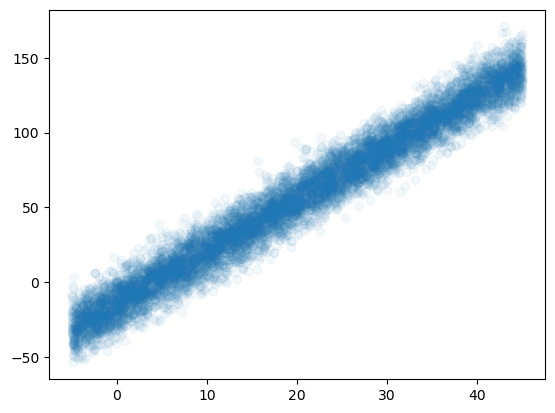

In [96]:
def generateData(func, samples=100, noise=1, lower=-5, upper=45):
    x = np.random.uniform(lower, upper, samples)
    vfunc = np.vectorize(func)
    y = vfunc(x)
    n = np.random.normal(0, noise, samples)
    y = y+n
    return x, y

def line(x):
    return 3.48*x-13.76

X, y = generateData(line, samples=10000, noise=10)
df = pd.DataFrame({'X': X, 'y': y})
plt.scatter(X,y,alpha=0.05)

### Split the code into training set and test set

In [97]:
train_data, test_data = train_test_split(df, test_size=0.10)

### Initialize model, data loader, trainer and fit model to data

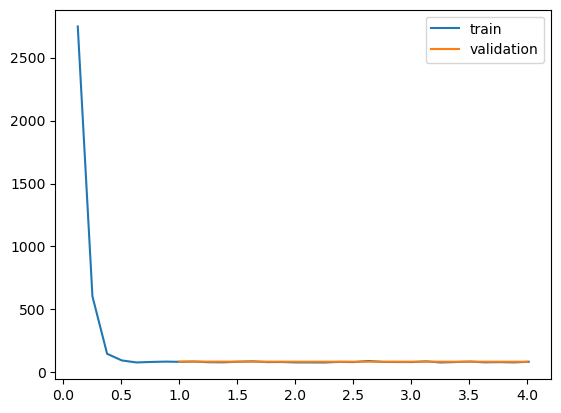

In [98]:
model = LinearRegression(len(train_data.columns)-1, 0.001)
data = Data(train_data, 0.1)
trainer = Trainer(max_epochs=4)
trainer.fit(model, data, 1024)
model.plot()

### Evaluate the model's "accuracy" or fit

In [100]:
test_tensor = torch.tensor(test_data.values, dtype=torch.float)
y_pred = model.forward(test_tensor[:, :-1]).detach().numpy()
y = test_tensor[:, -1].numpy()
print("Mean Squared Error: ", mean_squared_error(y, y_pred))
print("R2 Score: ", r2_score(y, y_pred))
print("Predicted slope ", model.w.detach().numpy())
print("Predicted intercept ", model.b.detach().numpy())

Mean Squared Error:  172.88759
R2 Score:  0.9335615349523014
Predicted slope  [[3.036716]]
Predicted intercept  [-0.04958556]


### Compare our model to Sklearn's Linear Regression Model

In [101]:
reg = skLinearRegression().fit(train_data[train_data.columns[:-1]], train_data[train_data.columns[-1]])

y_pred = reg.predict(test_data[test_data.columns[:-1]])
y = test_data[test_data.columns[-1]]

print("Mean Squared Error: ", mean_squared_error(y, y_pred))
print("R2 Score: ", r2_score(y, y_pred))

Mean Squared Error:  102.26854596371432
R2 Score:  0.9606995190521043


## AP Stats Student Score Dataset

In [24]:
df = pd.read_csv("Combined-Data-Table.csv")
df = df.dropna()
display(df)

,S1 Overall,S1 Assignments,S1 Exit Tickets,S1 MCQ Tests,S1 FRQ Tests,S1 Final Exam,S2 Overall,S2 Assignments,S2 Exit Tickets,S1 MCQ Tests.1,S2 FRQ Tests,S2 Final Exam,AP Exam
0,87,82.52,98.75,84.0,92.50,77.5,85.0,82.05,97.33,83.64,87.31,77.5,4.0
1,94,100.00,98.75,89.0,89.17,97.5,91.0,100.00,100.00,85.91,87.69,82.5,4.0
2,97,100.00,100.00,95.0,97.50,90.0,98.0,100.00,100.00,95.45,94.62,100.0,5.0
3,96,100.00,100.00,93.0,97.50,90.0,94.0,99.49,100.00,91.36,93.46,87.5,5.0
4,96,100.00,100.00,89.0,95.00,97.5,97.0,100.00,100.00,90.00,98.85,97.5,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,92,98.25,97.33,91.0,90.00,85.0,92.0,95.83,100.00,88.18,93.18,85.0,5.0
219,89,87.63,98.67,82.0,88.50,95.0,91.0,86.55,100.00,92.73,93.64,82.5,5.0
220,94,94.39,98.67,91.0,96.00,90.0,84.0,68.33,97.50,89.09,89.09,77.5,4.0
221,83,98.25,92.00,71.0,83.50,75.0,77.0,89.41,81.25,70.91,83.64,57.5,3.0


In [42]:
train_data, test_data = train_test_split(df, test_size=0.10)

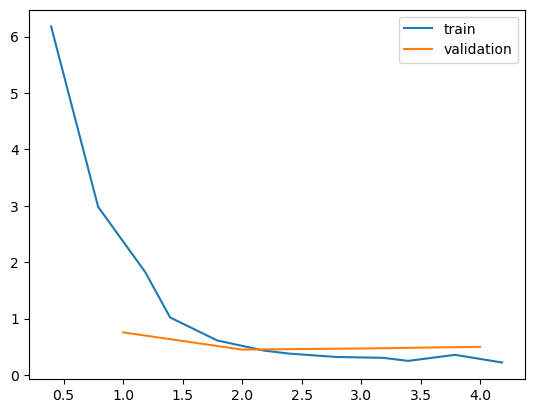

In [57]:
model = LinearRegression(len(train_data.columns)-1, 0.000003)
data = Data(train_data, 0.1)
trainer = Trainer(max_epochs=4)
trainer.fit(model, data, 64)
model.plot()

In [58]:
test_tensor = torch.tensor(test_data.values, dtype=torch.float)
y_pred = torch.round(model.forward(test_tensor[:, :-1])).detach().numpy()
y = test_tensor[:, -1].numpy()
accuracy_score(y, y_pred)

0.2857142857142857

## Popular Song Ranking Dataset

In [59]:
df = pd.read_csv("song_data.csv")
df = df.dropna()
df = df.drop_duplicates()
display(df)

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18830,Let It Breathe,60,159645,0.893000,0.500,0.151,0.000065,11,0.1110,-16.107,1,0.0348,113.969,4,0.300
18831,Answers,60,205666,0.765000,0.495,0.161,0.000001,11,0.1050,-14.078,0,0.0301,94.286,4,0.265
18832,Sudden Love (Acoustic),23,182211,0.847000,0.719,0.325,0.000000,0,0.1250,-12.222,1,0.0355,130.534,4,0.286
18833,Gentle on My Mind,55,352280,0.945000,0.488,0.326,0.015700,3,0.1190,-12.020,1,0.0328,106.063,4,0.323


In [60]:
df = df.reindex(columns=df.columns[:0:-1])
train_data, test_data = train_test_split(df, test_size=0.10)

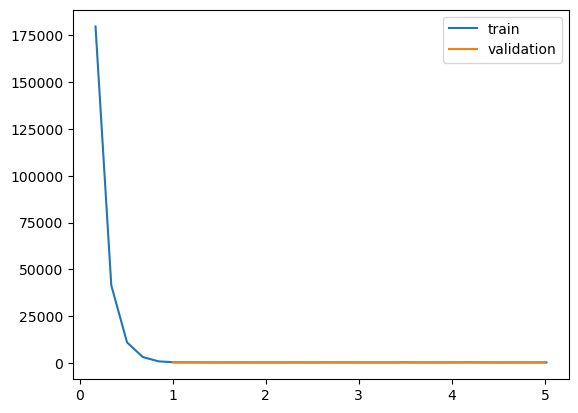

In [87]:
model = LinearRegression(len(train_data.columns)-1, 0.00000000001)
data = Data(train_data, 0.1)
trainer = Trainer(max_epochs=5)
trainer.fit(model, data, 2048)
model.plot()

In [88]:
test_tensor = torch.tensor(test_data.values, dtype=torch.float)
y_pred = model.forward(test_tensor[:, :-1]).detach().numpy()
y = test_tensor[:, -1].numpy()
print("Mean Squared Error: ", mean_squared_error(y, y_pred))
print("R2 Score: ", r2_score(y, y_pred))

Mean Squared Error:  586.9892
R2 Score:  -0.4127826702023678
